In [96]:
#importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import warnings

First thing we need to do is load the data from our cleaning process:

In [97]:
songs = pd.read_csv('../data/songs_data_cleaned.csv')
songs.head()
songs.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [98]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635600 entries, 0 to 635599
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   spotify_id          635600 non-null  object 
 1   name                635600 non-null  object 
 2   artists             635600 non-null  object 
 3   daily_rank          635600 non-null  int64  
 4   daily_movement      635600 non-null  int64  
 5   weekly_movement     635600 non-null  int64  
 6   country             635600 non-null  object 
 7   snapshot_date       635600 non-null  object 
 8   popularity          635600 non-null  int64  
 9   is_explicit         635600 non-null  bool   
 10  duration_ms         635600 non-null  int64  
 11  album_name          635600 non-null  object 
 12  album_release_date  635600 non-null  object 
 13  danceability        635600 non-null  float64
 14  energy              635600 non-null  float64
 15  key                 635600 non-nul

One of the first things we need to do is convert the dates to date formats:

In [99]:
songs['snapshot_date'] = pd.to_datetime(songs['snapshot_date'])
songs['album_release_date'] = pd.to_datetime(songs['album_release_date'])
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635600 entries, 0 to 635599
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   spotify_id          635600 non-null  object        
 1   name                635600 non-null  object        
 2   artists             635600 non-null  object        
 3   daily_rank          635600 non-null  int64         
 4   daily_movement      635600 non-null  int64         
 5   weekly_movement     635600 non-null  int64         
 6   country             635600 non-null  object        
 7   snapshot_date       635600 non-null  datetime64[ns]
 8   popularity          635600 non-null  int64         
 9   is_explicit         635600 non-null  bool          
 10  duration_ms         635600 non-null  int64         
 11  album_name          635600 non-null  object        
 12  album_release_date  635600 non-null  datetime64[ns]
 13  danceability        635600 no

This dataset contains a song in a country on a specific day. The type of data can be broken down by:


**Song Identification**
- song ID
- name
- artist
- Album name

**Country Identification**
- code_standard

**Date Identification**
- snapshot_date

**Song descriptors**
- is_explicit
- duration_ms
- album_release_date
- danceability
- energy
- key
- loudness
- mode
- acousticness
- instrumentalness
- liveness
- valence
- tempo
- time_signature
- spotify_id
- name
- artists
- album_name

**Country Socioeconomic Characteristics**
- child_mort
- exports
- health
- imports
- income
- inflation
- life_expec
- gdpp
- hap_score
- pop2021
- chistians_p
- muslims_p
- unaffiliated_p
- hindus_p
- buddhists_p
- folkReligions_p
- other_p
- jews_p
- hdicode
- region
- hdi_rank_2021
- gnipc_2021

The final goal is to predict wether a song will make it to the top 5 at a specific country (given the characteristics of the song) To do this, we will use the song specific characteristics as well as the country identification variables.

The first thing we want to look at is the spread of the **Daily Rank** and the ditribution, as well as the values that are considering top5 to understand the type of data we are dealing with and if we have any skewed info on specific daily ranks:

<Axes: xlabel='daily_rank', ylabel='Count'>

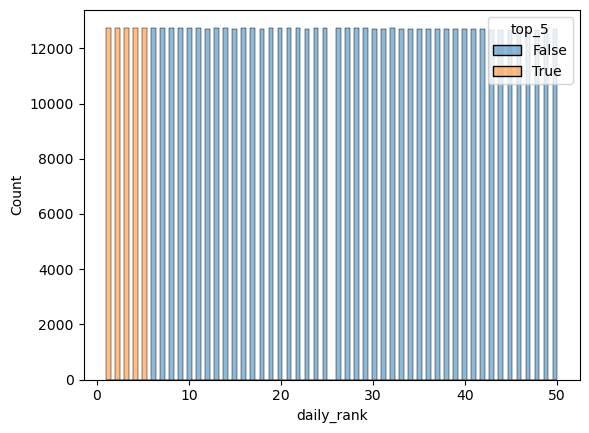

In [100]:
sns.histplot(x = 'daily_rank', hue='top_5', data = songs, bins = 100)

This is a good sign as it shows our data includes data whitin all ranges of the 'daily rank'. We could consider this entire data set as the whole universe of songs. We can also see that the variable to predict "top_5" is only the cases where the daily rank is 1-5. With this in mind, we can use daily_rank as a potential predictor for this exercise.

Next we should look at the correlations between our potential "variables" with each other as well as with the ranking. to identify which would potentially be the best to explain our data.

One thing to call out is that the "Country" is a text value and as it is we cannot use it to calculate a correlation with the other variables. for now we will use country specific information (like GDP and CPI) to test for correlation.

The first thing we need to do is create a subset of our main dataset, including only numerical variables to be able to calculate correlation (pearson and spearman):

In [101]:
songs_nm = songs.loc[: , songs.dtypes != 'object']

In [102]:
#Review the correlation matrix (Pearson)
corre = songs_nm.corr()

<Axes: >

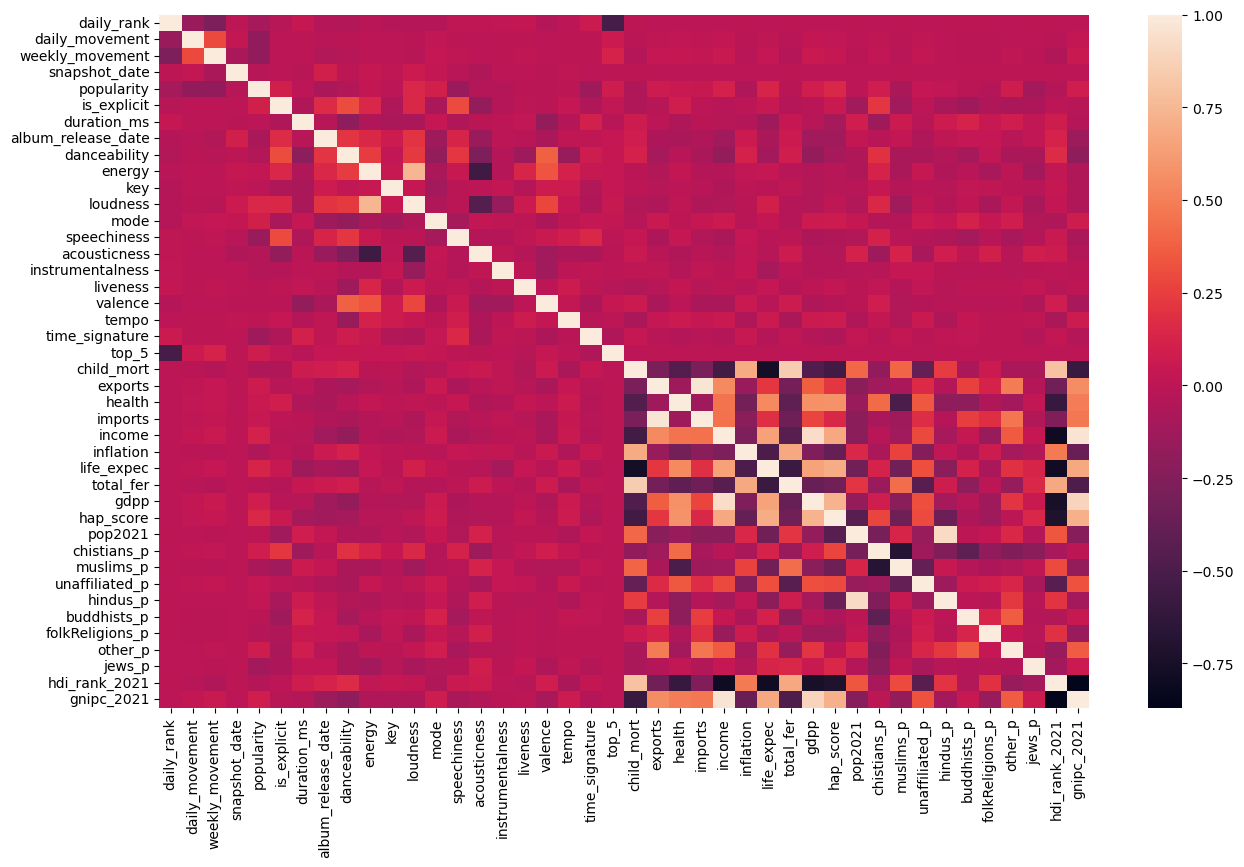

In [103]:
#create the heatmap of the correlation (pearson):
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(corre)

From these results, there seem to be a several correlated pairs:
<ul>
    <li>daily_rank with top_5: expected. We will only keep top_5.</li>
    <li>energy-loudnes with a pearson correlation of 0.7393</li>
    <li>child_mort-total_fer with a pearson correlation of 0.849</li>
    <li>child_mort-hdi_rank_2021 with a pearson correlation of 0.801</li>
    <li>child_mort-life_expec with a pearson correlation of -0.769</li>
    <li>exports-imports with a pearson correlation of 0.97</li>
    <li>income-gnipc_2021 with a pearson correlation of 0.957</li>
    <li>income-gdpp with a pearson correlation of 0.933</li>
    <li>income-hdi_rank_2021 with a pearson correlation of -0.79</li>
    <li>life_expec-hdi_rank_2021 with a pearson correlation of -0.785</li>
    <li>gdpp-gnipc_2021 with a pearson correlation of 0.885</li>
    <li>gdpp-hap_score with a pearson correlation of 0.725</li>
    <li>gdpp-hdo_rank_2021 with a pearson correlation of -0.751</li>
    <li>hap_score-gnipc_2021 with a pearson correlation of 0.719</li>
    <li>hap_score-hdi_rank_2021 with a pearson correlation of -0.720</li>
    <li>pop2021-hindus_p with a pearson correlation of 0.917</li>
    <li>hdi_rank_2021-gnipc_2021 with a pearson correlation of -0.869</li>
</ul>
We can begin by reviewing the song related pairs:

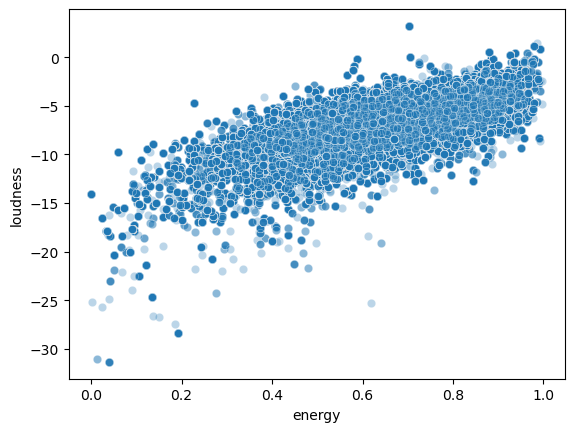

In [104]:
# Plot energy against loudness
sns.scatterplot(x='energy', y='loudness',alpha = 0.3, data = songs)
plt.show()

It looks like there is a fairly strong and positive correlation between the loudness and the energy of the song. based on this result, <span style="background-color: #FFFF00"> we will be dropping the loudness column and keeping only energy. </span> <br>

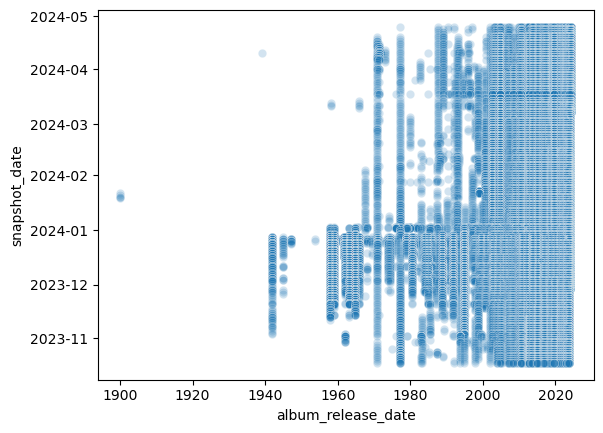

In [105]:
# Plot energy against loudness
sns.scatterplot(x='album_release_date', y='snapshot_date',alpha = 0.2, data = songs)
plt.show()

From this preliminar graph, theres no clear correlation between the snapshot_date and album_release_date, however the data is not showing the entire picture as the snapshot date starts in october 2023 while the relase date reverts all the way back to 1900. to do this, lets only take a look at album release dates closer to the min snapshot_date

In [106]:
songs['snapshot_date'].min()

Timestamp('2023-10-18 00:00:00')

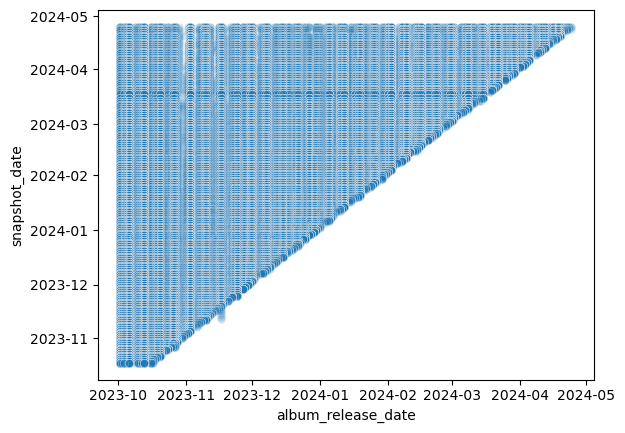

In [107]:
# Plot snapshot_date against album_release_date
sns.scatterplot(x='album_release_date', y='snapshot_date',alpha = 0.2, data = songs[songs['album_release_date'] > np.datetime64('2023-10-01')])
plt.show()

As expected, there is a clear correlation on the tail end of this data and this is because logically we cannot expect an album to be in the top50 on a date earlier than the relase date. Given these results, we dont need to take any further action on these 2 variables. Now, lets move on to revieweing the socioeconomic correlations:

In [108]:
#plotting up to 4 graphs receiving tupples as input:
def plotPairs(p1, p2=(0,0), p3=(0,0), p4=(0,0)):
    fig,ax = plt.subplots(nrows=2,ncols=2, figsize=(9,9))
    sns.scatterplot(ax=ax[0,0], x=p1[0], y=p1[1], alpha = 0.2, data = songs)
    ax[0,0].set_title(f"{p1[0]} Vs. {p1[1]} relation graph:")
    if p2[0] != 0:
        sns.scatterplot(ax=ax[0,1], x=p2[0], y=p2[1], alpha = 0.2, data = songs)
        ax[0,1].set_title(f"{p2[0]} Vs. {p2[1]} relation graph:")
    if p3[0] != 0:
        sns.scatterplot(ax=ax[1,0], x=p3[0], y=p3[1], alpha = 0.2, data = songs)
        ax[1,0].set_title(f"{p3[0]} Vs. {p3[1]} relation graph:")
    if p4[0] != 0:
        sns.scatterplot(ax=ax[1,1], x=p4[0], y=p4[1], alpha = 0.2, data = songs)
        ax[1,1].set_title(f"{p4[0]} Vs. {p4[1]} relation graph:")

    plt.show()

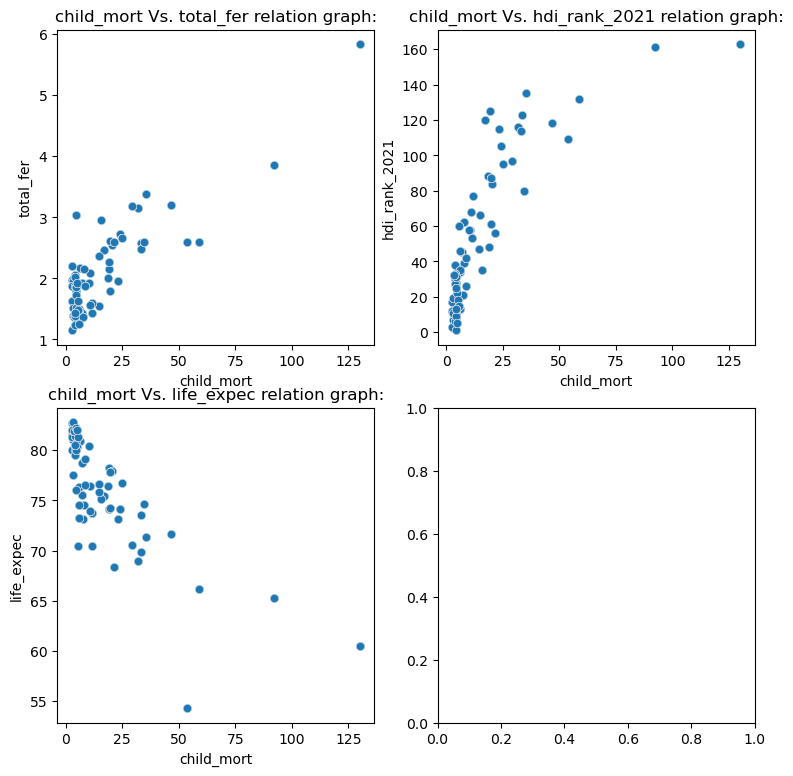

In [109]:
plotPairs(('child_mort','total_fer'), ('child_mort','hdi_rank_2021'), ('child_mort','life_expec'))

for Child Mortality, there seems to be high correlation but not direct correlation with either of the variables called out earlier. We can keep these variables to try and explain our data.
Next we will look at exports-imports as well as the several high correlation pairs for income:

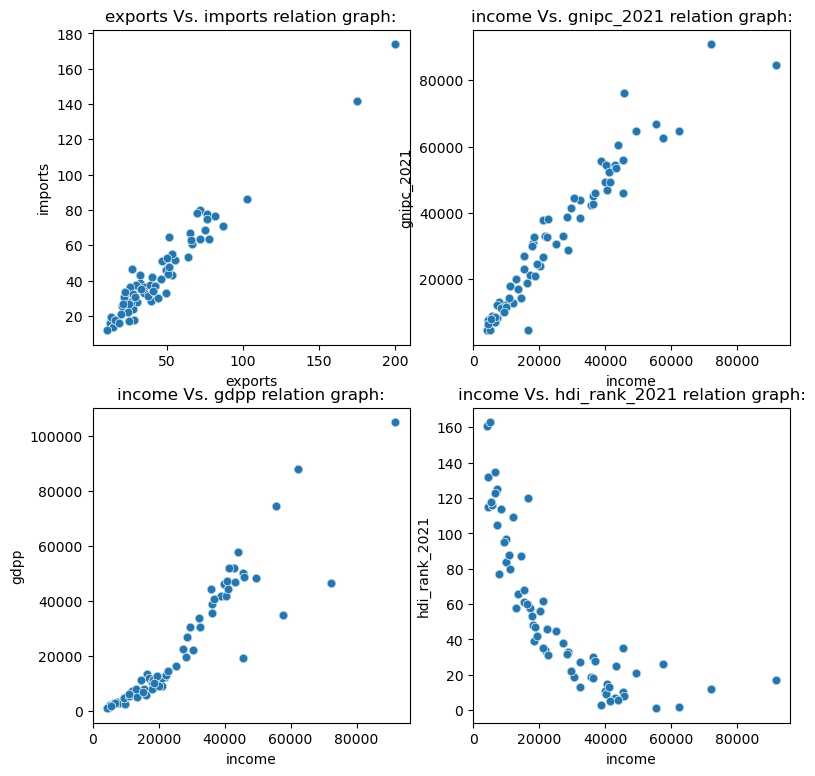

In [110]:
plotPairs(('exports', 'imports'), ('income', 'gnipc_2021'), ('income', 'gdpp'), ('income', 'hdi_rank_2021'))

Regarding imports-exports, it looks like there is a very strong correlation between these two. We will instead replace these 2 with a exports/imports rate.
Regarding income, there seems to be a very strong correlation with borh gnipc and gdpp. We will remove income altogether.


In [111]:
songs['imp_exp_rate']=songs['exports']/songs['imports']
songs = songs.drop(columns=['imports', 'exports', 'income'])

Next we are going to look at life expectation vs hdi rank as well as gdpp:

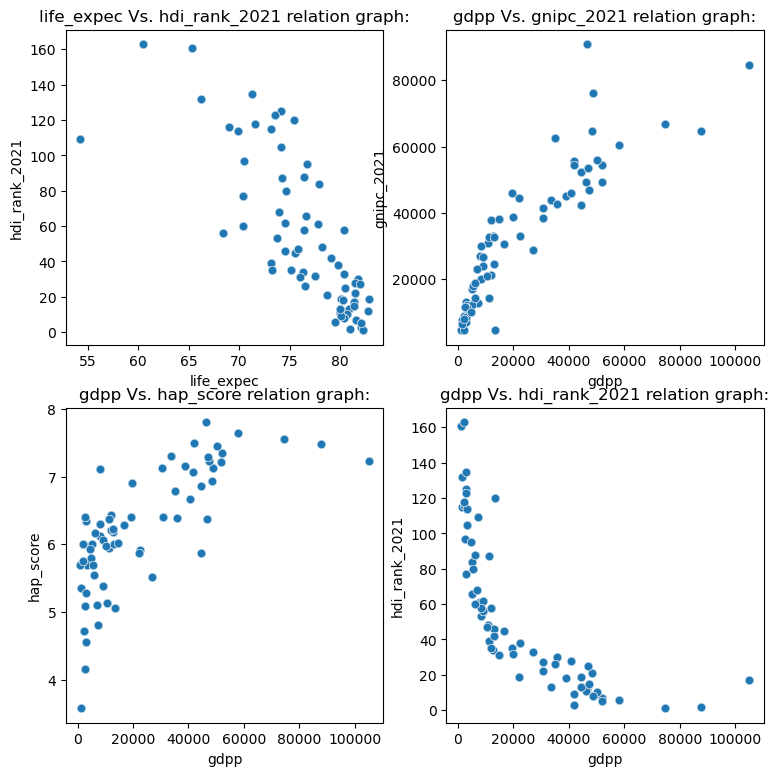

In [112]:
plotPairs(('life_expec', 'hdi_rank_2021'), ('gdpp', 'gnipc_2021'), ('gdpp', 'hap_score'), ('gdpp', 'hdi_rank_2021'))

Looking at these variables. It looks like these have stron correlations but they are not linearly correlated. as such, we believe there is enough information in these variables to not drop them from the analysis. Finally lets look at the last set of correlated variables:

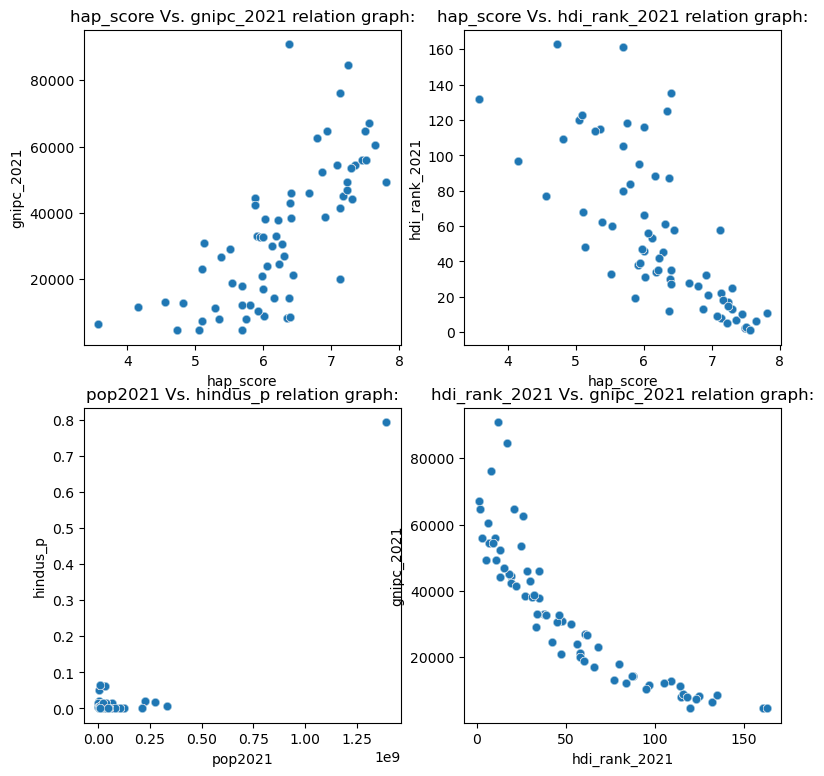

In [113]:
plotPairs(('hap_score','gnipc_2021'),('hap_score','hdi_rank_2021'),('pop2021','hindus_p'),('hdi_rank_2021','gnipc_2021'))

For the last 4 pairs, we again see mild correlations with the hdi_ranlk_2021 and a couple of other variables. as a results, based on these and the previous results, we will drop hdi_rank_2021 as a lot of the information from this variable seems to be included in the existing variables.

In [114]:
songs = songs.drop(columns=['hdi_rank_2021'])

<h2>Data correlation</h2>
<h5>Country Specific</h5>
Next thing we are going to want to do is identify any potential correlation from our socioeconomic variables and our predicted variable (daily_rank). To do this, we will first choose the country specific varibles and group them:

In [115]:
#first we identify the variables that are country specific as well as the predicted variable
song_test_1 = songs[['daily_rank', 'code_standard', 'child_mort', 'health',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'hap_score', 'pop2021',
       'chistians_p', 'muslims_p', 'unaffiliated_p', 'hindus_p', 'buddhists_p',
       'folkReligions_p', 'other_p', 'jews_p',
       'gnipc_2021', 'imp_exp_rate']]

In [116]:
#group these songs by country ('code_standard') and calculate the mean
songs_means = song_test_1.groupby('code_standard').mean()
songs_means.corr()['daily_rank'].sort_values()

gdpp              -0.471366
gnipc_2021        -0.324385
hap_score         -0.176511
imp_exp_rate      -0.141104
life_expec        -0.140538
unaffiliated_p    -0.110665
other_p           -0.040283
health            -0.030440
chistians_p       -0.023194
folkReligions_p   -0.002836
hindus_p           0.009848
jews_p             0.022893
buddhists_p        0.026411
inflation          0.034275
pop2021            0.046385
muslims_p          0.066838
total_fer          0.074747
child_mort         0.088097
daily_rank         1.000000
Name: daily_rank, dtype: float64

As we can see, there doesn't seem to be high correlation between our country specific socioeconomic variables and the daily_rank. the highest correlation would be with gdpp so lets take a look:

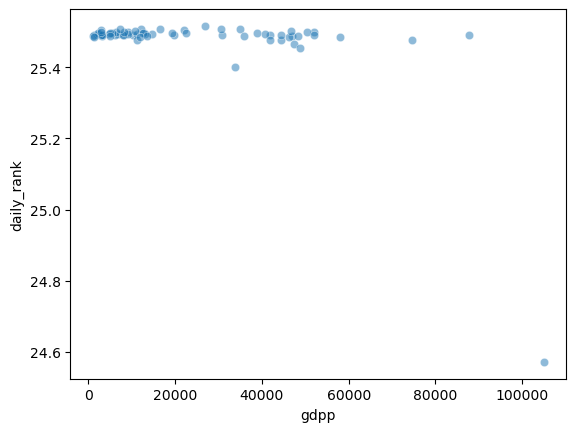

In [117]:
sns.scatterplot(y='daily_rank', x='gdpp', data = songs_means, alpha=0.5)
plt.show()

As expected, there is no clear correlation between the gdpp and daily_rank. Since this is the case, we can continue now to the song specific variables.

<h5>Song Specific variables:</h5>

The next thing we want to do is identify potential correlations within the existing data and the variable we are trying to predict. Before we can continue analyzing, since our data is so large and we want to be able to predict at country level, the first thing we are going to do is pick a couple of countries based on the average number of days a song remains in the top 5:

To do this we will create a function to plot 2 variables and use the color to identify wether these are top5 or not. We will do this for all the variables that could potentially describe the data:

In [118]:
# group the songs by the number of days on top 5 at each country to calculate the songs per country with the number of days in top 5
songsbycountry = pd.DataFrame(songs.groupby(['spotify_id', 'country'])['top_5'].sum().sort_values()).reset_index()

<Axes: xlabel='country', ylabel='top_5'>

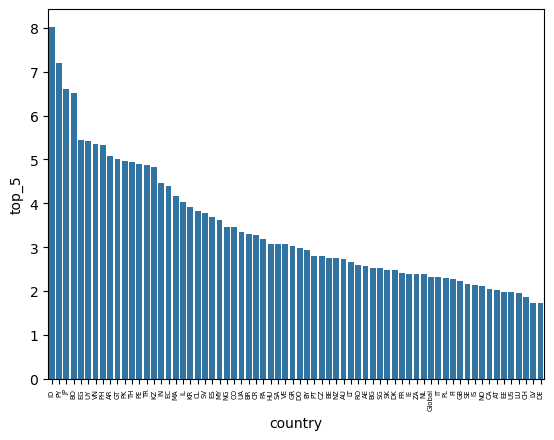

In [119]:
plt.xticks(rotation = 90, fontsize = 5)
sns.barplot(songsbycountry, x = 'country', y = 'top_5', estimator = 'mean', errorbar = None, order = songsbycountry.groupby('country')['top_5'].mean().sort_values(ascending = False).index)


In [120]:
countriesToReview = ['ID', 'PY', 'LV', 'DE']

It looks like ID and PY are the countries where songs remain on average the longest time on top_5, in contrast it looks like LV and DE are the countries where the songs remain the least amount of time on top_5. Lets use these 4 countries to review the behaviour and correlation of data.


In [121]:
res = pd.DataFrame(columns = songs.select_dtypes(exclude='object').columns)
for c in countriesToReview:
    songs_nm = songs.loc[songs['country']==c ,  songs.dtypes != 'object']
    temp = pd.DataFrame(songs_nm.corr()['daily_rank']).T
    temp['country'] = c
    res = pd.concat([res, temp], ignore_index = True)

C:\Users\Alfredo\AppData\Local\Temp\ipykernel_20636\2395939463.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, temp], ignore_index = True)


In [122]:
print(res.iloc[:,0:5])
print(res.iloc[:,5:10])
print(res.iloc[:,10:15])
print(res.iloc[:,15:20])
print(res.iloc[:,20:25])
print(res.iloc[:,25:30])
print(res.iloc[:,35:40])

   daily_rank  daily_movement  weekly_movement  snapshot_date  popularity
0         1.0       -0.113192        -0.216315      -0.000719   -0.162900
1         1.0       -0.107793        -0.184911      -0.000293   -0.315731
2         1.0       -0.171590        -0.281844       0.000429   -0.108818
3         1.0       -0.193038        -0.342505      -0.000221   -0.146784
   is_explicit  duration_ms  album_release_date  danceability    energy
0     0.116460     0.075039           -0.198145     -0.065084  0.028053
1    -0.070868     0.087320           -0.008746     -0.093667 -0.143574
2    -0.034191     0.145136           -0.049128     -0.009951  0.023527
3    -0.019038     0.061134            0.049461      0.004226  0.011164
        key  loudness      mode  speechiness  acousticness
0  0.023474  0.045353 -0.092096     0.066198     -0.061490
1 -0.119636 -0.087372 -0.193004     0.019613     -0.033790
2  0.000405 -0.000530 -0.094273     0.052895     -0.030383
3 -0.067343 -0.081935 -0.114786   

From the results, we are seeing that different countries in fact seem to have different appreciation for music characteristics:
**popularity:** which seems to influence the daily rank of a song 3X more in paraguay than the other 3 countries.
**explicit:** explicit songs seem to perform worse in countries where they last longer at the top_5, specifically indonesia where explicit songs are much more likely to be at a lower daily rank (away from the top 5)
**duration:** longer duration songs are more likely to be correlated with the daily rank in Latvia than the other 3 countries.
**tempo:** tempo seems to have stronger correlation to daily rank in latvia than the other countries.

Before we continue, lets start looking at the influence of these variables visually. to do this the first thing we will do is create a function to plot 2 variables and use the color to identify wether these are top5 or not, and then use it to see some of the influence on these countries:

In [123]:
def plt2(y):
    plt.close()
    sns.relplot(x='daily_rank', y=y, kind = 'scatter', hue='top_5', alpha = 0.2, data = songs[songs['country'].isin(countriesToReview)], col = 'country')

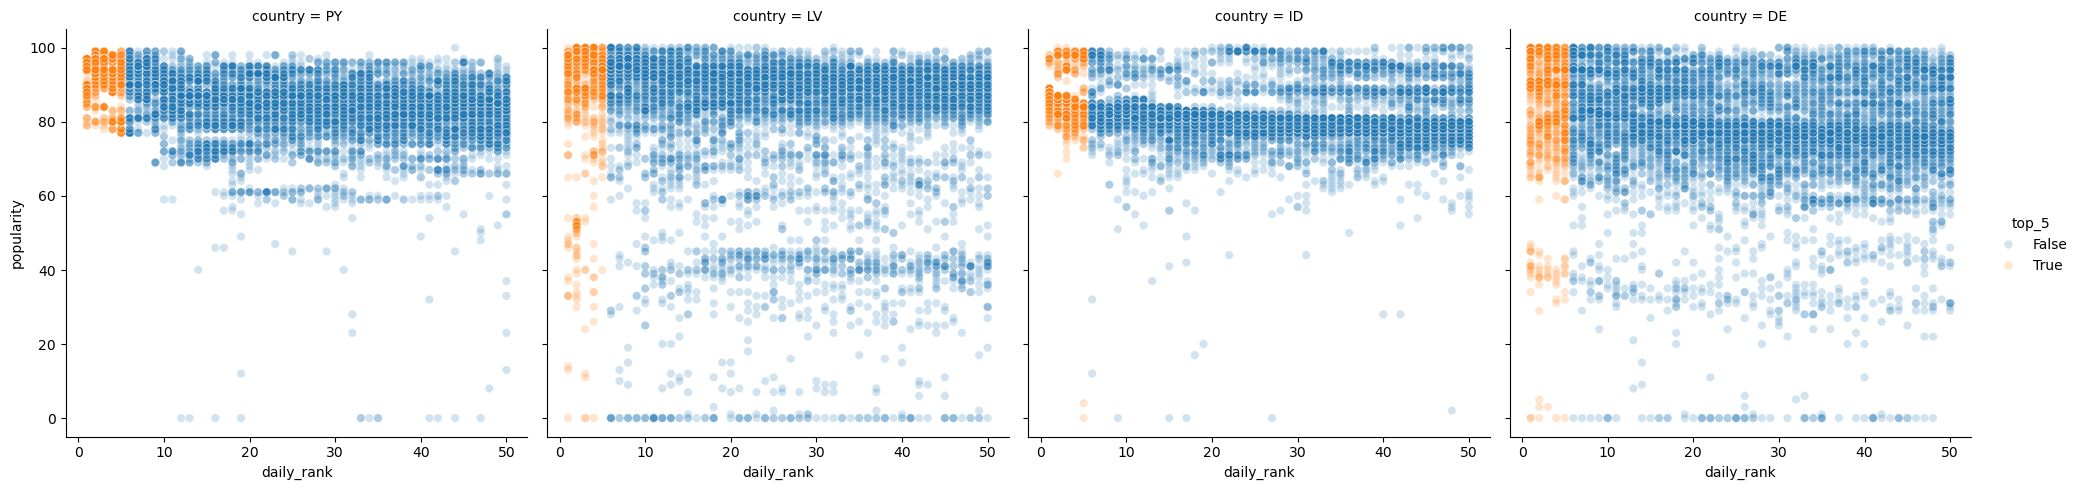

In [124]:
plt2('popularity')

By looking at popularity vs daily ranks, we can see that for countries like Paraguay and Indonesia, the popularity is usually over 80 for top_5 songs and slowly decreases as the ranking is higher. on the other hand, we see the other 2 countries (Latvia and Germany) to have the top_5 songs spread across different popularity and a much lower correlation between popularity and daily rank.

Next lets take a look at the impact on is_explicit:

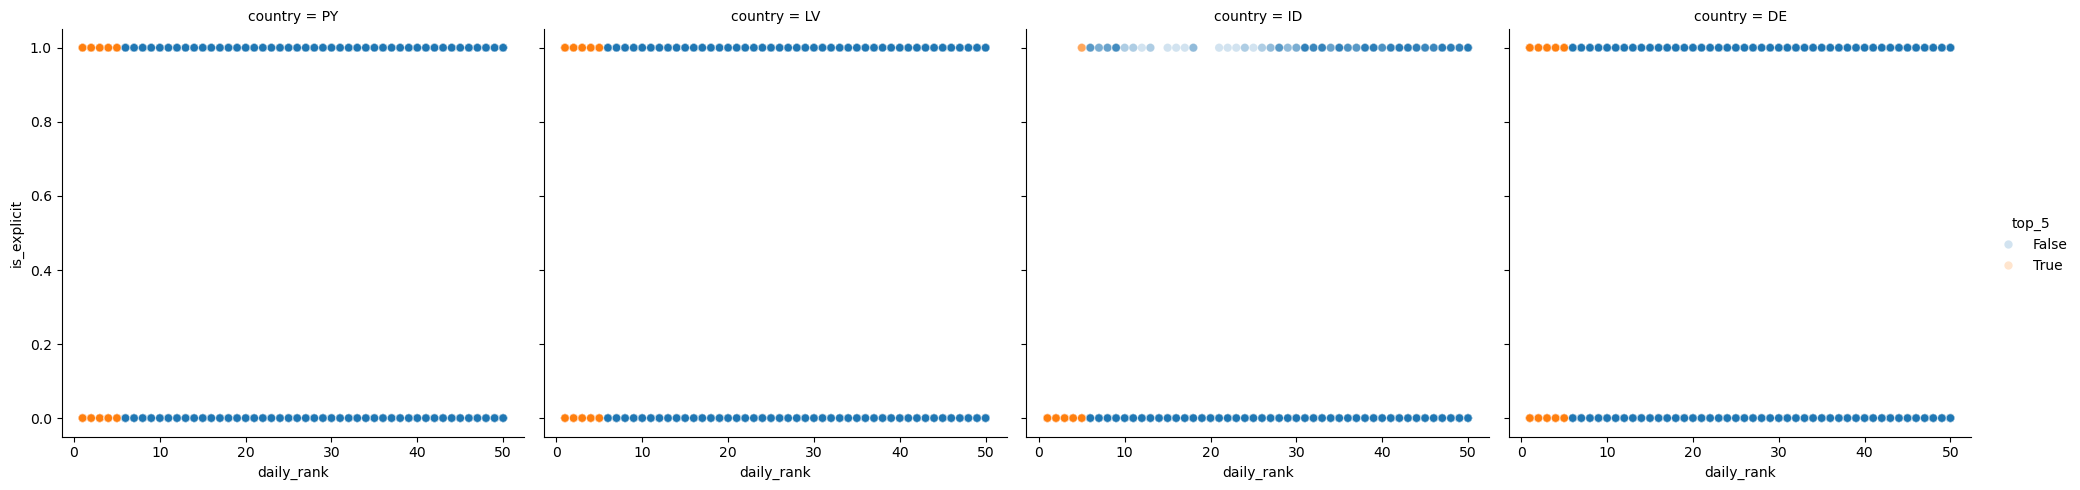

In [125]:
plt2('is_explicit')

From what we can see, it looks like explicit songs perform somewhat equally at most countries but Indonesia. It looks that explicit songs rarely make it to the top_5 and when they do they usually never make it higher than 5.

We will next do this analysis for duration:

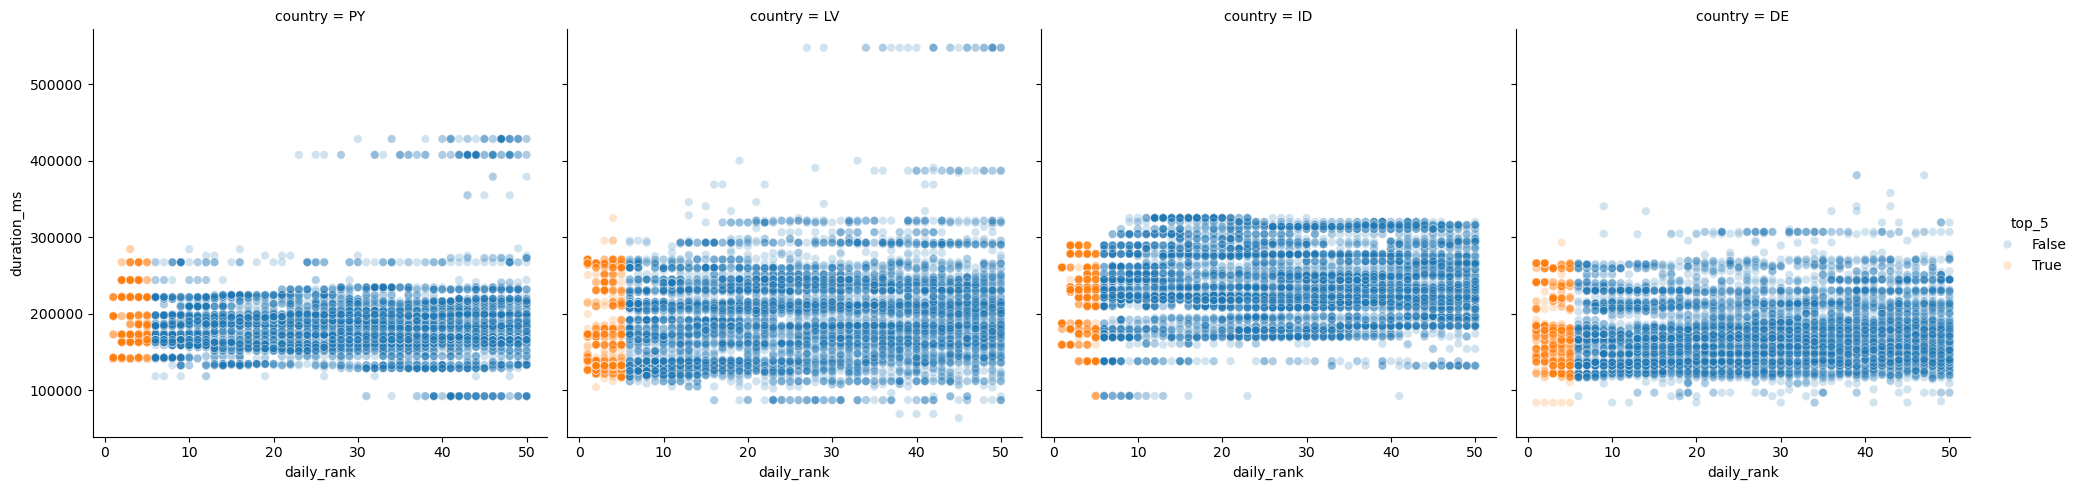

In [126]:
plt2('duration_ms')

Duration also gives us a clear picture for the differences in these countries. it looks like in general top_5 songs are longer than 150K ms and shorter than 300K ms (2.5 to 5 minutes long). However, when we look at the whole top_50 songs, we can see that the spread around the 3.3 minute mark is wider or narrower depending on the country and particularly for Indonesia, songs in the top50 are closely capped at a bit over 5 minutes. 

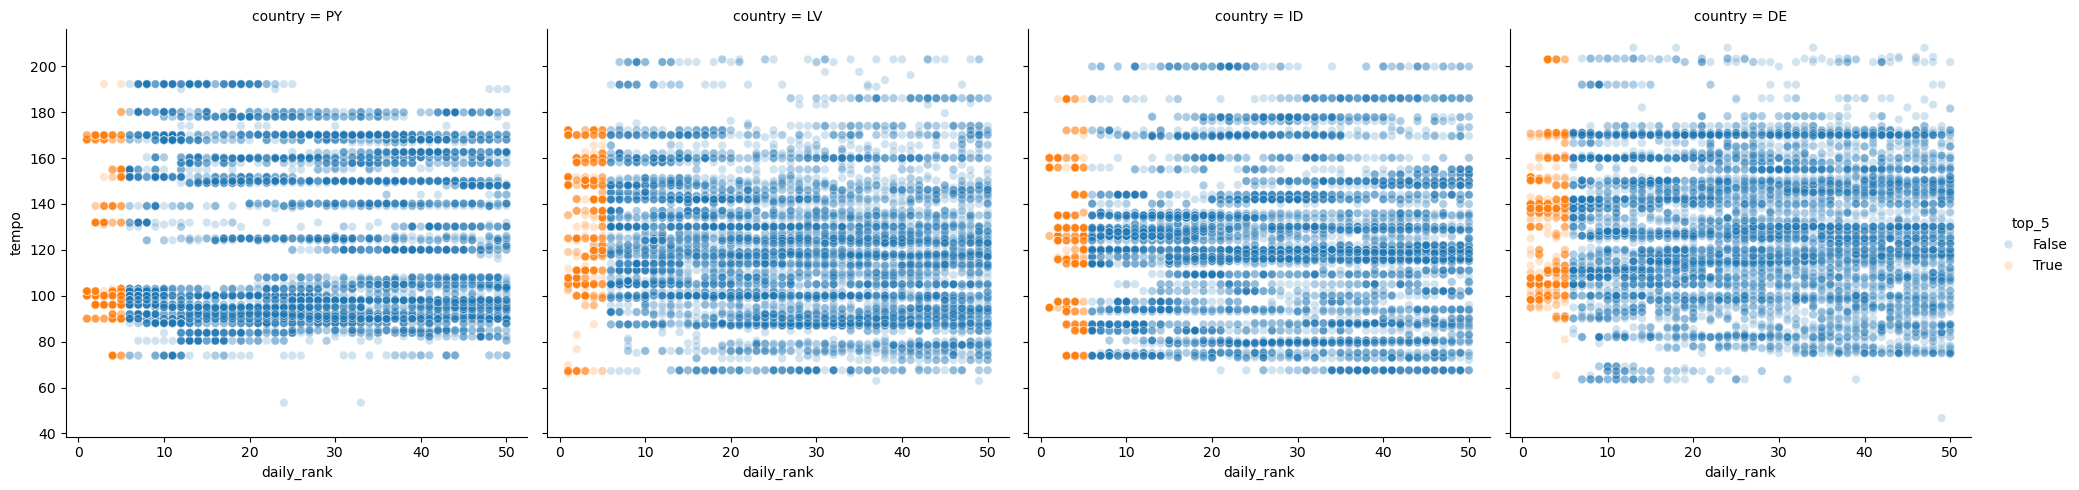

In [127]:
plt2('tempo')

Regarding tempo, once again the preferred tempo driving the top_5 and top_50 varies between countries. it is notable that Latvia seems to have the smallest interval of preferred tempo for their top_5 songs whole there seems to be a preference for slower tempo songs at Paraguay vs Germany.
One interesting fact is that Paraguay seems to have bands of tempo where no song seems to fall in (for the whole top_50) like 120 or 145. This could be an interesting deep dive. 

One of the things that mostly jumped from our previous analysis was the fact that explicit songs seem to perform overall lower in Indonesia than other countries. To test this, we will run a statistical analysis on wether there is an actual difference in the performance.


In [128]:
songs.columns

Index(['spotify_id', 'name', 'artists', 'daily_rank', 'daily_movement',
       'weekly_movement', 'country', 'snapshot_date', 'popularity',
       'is_explicit', 'duration_ms', 'album_name', 'album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'top_5', 'code_standard', 'child_mort', 'health',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'hap_score', 'pop2021',
       'chistians_p', 'muslims_p', 'unaffiliated_p', 'hindus_p', 'buddhists_p',
       'folkReligions_p', 'other_p', 'jews_p', 'hdicode', 'region',
       'gnipc_2021', 'imp_exp_rate'],
      dtype='object')

In [129]:
def sampler(data, n):
    return np.random.choice(data, n)

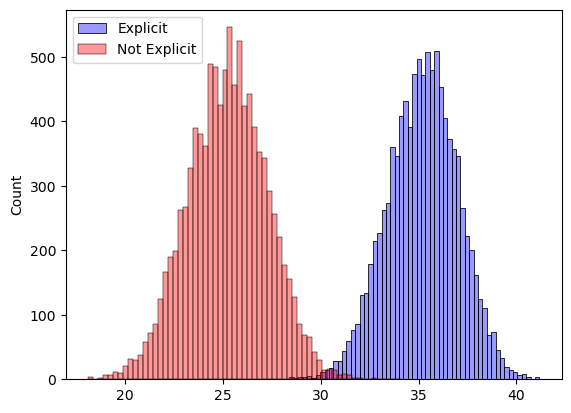

In [130]:
samples = np.empty(10000)
id_e = songs[(songs['country'] == 'ID') & (songs['is_explicit'] == True)]['daily_rank']
for i in range(len(samples)):
    samples[i] = sampler(id_e, 50).mean()

samples2 = np.empty(10000)
id_ne = songs[(songs['country'] == 'ID') & (songs['is_explicit'] == False)]['daily_rank']
for i in range(len(samples2)):
    samples2[i] = sampler(id_ne, 50).mean()

sns.histplot(samples, color = 'b', alpha=0.4)
sns.histplot(samples2, color = 'r', alpha = 0.4)
plt.legend(['Explicit', 'Not Explicit'])

In [131]:
from scipy import stats

stats.ttest_ind(id_e, id_ne)

TtestResult(statistic=11.401150586763327, pvalue=6.46843788189706e-30, df=9454.0)

As we can see above. The average ranking of 50 songs seem to have different distributions (for Indonesia) as the distribution of the average ranking are around 25 for not explicit songs but it goes to 35 for explicit songs. 

When running a T test to test the null hypothesis that the average ranking of songs is independent for explict and not explicit songs in Indonesia. The result is a p-value close to 0, which means we can refuse the null hypothesis and confirm that wether a sont is or not explicit has an impact on the overall ranking of the song for Indonesia.

Lets take a look at the socioeconomic variables for the countries to identify differences:

In [132]:
songs_means.loc[countriesToReview]

,daily_rank,child_mort,health,inflation,life_expec,total_fer,gdpp,hap_score,pop2021,chistians_p,muslims_p,unaffiliated_p,hindus_p,buddhists_p,folkReligions_p,other_p,jews_p,gnipc_2021,imp_exp_rate
code_standard,,,,,,,,,,,,,,,,,,,
ID,25.486992,33.3,2.61,15.300,69.9,2.48,3110.0,5.286,276361783.0,0.098631,0.871751,0.001000,0.016883,0.007170,0.003126,0.001417,0.000021,11466.06836,1.084821
PY,25.490868,24.1,5.87,6.100,74.1,2.73,3230.0,5.692,7219638.0,0.967492,0.000774,0.010836,0.000774,0.000774,0.017028,0.001548,0.000774,12349.28600,1.069903
LV,25.475359,7.8,6.68,-0.812,73.1,1.36,11300.0,5.950,1866942.0,0.552632,0.002193,0.434211,0.002193,0.002193,0.002193,0.002193,0.002193,32803.23423,0.974592
DE,25.489375,4.2,11.60,0.758,80.1,1.39,41800.0,7.076,83900473.0,0.686915,0.057830,0.247236,0.000972,0.002551,0.000486,0.001215,0.002794,54534.21682,1.140162


It looks like Indonesia has overall higher inflation, child mortality, the most rate of muslims, the lowest rate of jews and the lowest gross national income per capita.
Before we can continue looking at the correlation of song specific variables to the daily rank, lets first build a useful function to test and view the difference in the top_5 songs at a given country:

In [133]:
def test_variable(country, variable):
    samples = np.empty(10000)
    samples2 = np.empty(10000)
    sng_on = songs[(songs['country'] == country) & (songs['top_5'] == True)][variable]
    sng_off = songs[(songs['country'] == country) & (songs['top_5'] == False)][variable]
    for i in range(len(samples)):
        samples[i] = sampler(sng_on, 50).mean()


    for i in range(len(samples2)):
        samples2[i] = sampler(sng_off, 50).mean()

    sns.histplot(samples, color = 'b', alpha=0.4)
    sns.histplot(samples2, color = 'r', alpha = 0.4)
    plt.legend(['Top_5', 'Not_Top_5'])
    
    print(stats.ttest_ind(sng_on, sng_off))

TtestResult(statistic=5.186773749201466, pvalue=2.184006924382189e-07, df=9454.0)


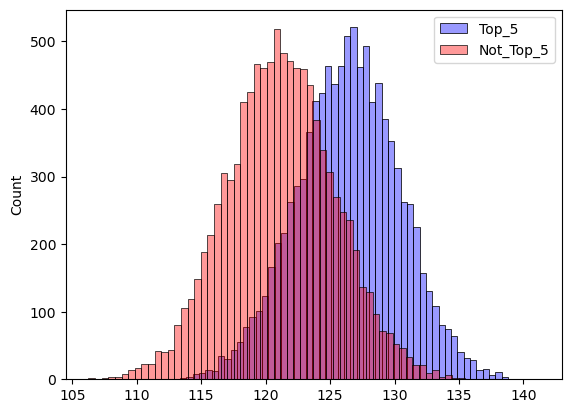

In [134]:
test_variable('ID', 'tempo')

We can see that for Indonesia, the tempo is overall diferent for top_5 and not top_5 songs and using a t-statist test we can confirm that the average tempo for top_5 songs is higher than not top_5 songs. This results seem to be replicated at our other 3 countries:

TtestResult(statistic=2.5767069995074965, pvalue=0.009989893002991463, df=9316.0)


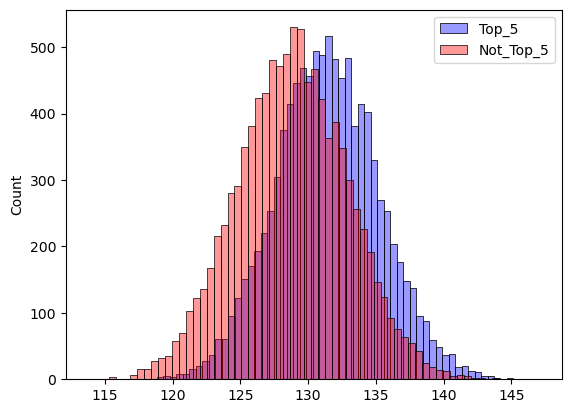

In [135]:
test_variable('DE', 'tempo')

TtestResult(statistic=-7.857091719541391, pvalue=4.370468550521221e-15, df=9251.0)


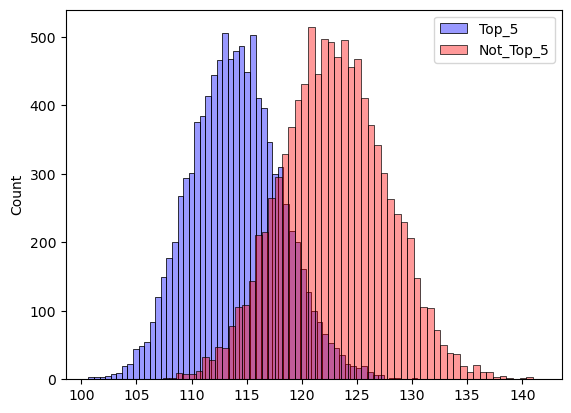

In [136]:
test_variable('PY', 'tempo')

TtestResult(statistic=13.882282508801492, pvalue=2.2008768454902194e-43, df=9271.0)


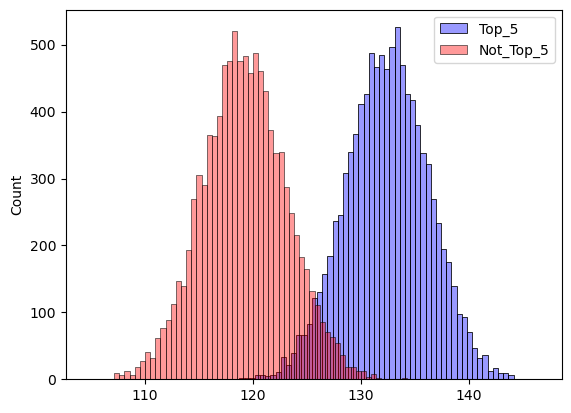

In [137]:
test_variable('LV', 'tempo')

These results are promising as it looks like there is enough evidence to believe that tempo as well as explicit content makes a difference in the overall performance of a song based on the country as well as the chances of it being in the top5. It looks like we can use the variables Is explicit, Duration, Danceability, Energy, Key, Loudness, Mode, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo and Time Signature to try and predict the likelihood of a song making it to the top 5 in a specifc country.

Before we go ahead and encode our categorical variables, we need to decide what to do with our N/A rows. lets confirm how many of the current rows are N/A:

In [138]:
songs.isna().sum()

spotify_id               0
name                     0
artists                  0
daily_rank               0
daily_movement           0
weekly_movement          0
country                  0
snapshot_date            0
popularity               0
is_explicit              0
duration_ms              0
album_name               0
album_release_date       0
danceability             0
energy                   0
key                      0
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
time_signature           0
top_5                    0
code_standard         9204
child_mort            9204
health                9204
inflation             9204
life_expec            9204
total_fer             9204
gdpp                  9204
hap_score             9204
pop2021               9204
chistians_p           9204
muslims_p             9204
u

In [139]:
#find the countries with missing values
songs[songs.child_mort.isna()]['country'].value_counts()

country
Global    9204
Name: count, dtype: int64

It looks like the "country" with all the N/As is the Global indicator. Since the Global indicator doesnt have country specific variables, we will fill with the mean or median as needed:

In [140]:
#figure out what columns need to adjust and how:
nacounts = pd.DataFrame({'na_count':songs.isna().sum(), 'type':songs.dtypes})
print(nacounts[nacounts['na_count']>0])

                 na_count     type
code_standard        9204   object
child_mort           9204  float64
health               9204  float64
inflation            9204  float64
life_expec           9204  float64
total_fer            9204  float64
gdpp                 9204  float64
hap_score            9204  float64
pop2021              9204  float64
chistians_p          9204  float64
muslims_p            9204  float64
unaffiliated_p       9204  float64
hindus_p             9204  float64
buddhists_p          9204  float64
folkReligions_p      9204  float64
other_p              9204  float64
jews_p               9204  float64
hdicode              9204   object
region               9204   object
gnipc_2021           9204  float64
imp_exp_rate         9204  float64


Based on these results, the code_standard will be replaced with 'GLB', the region will be 'GLB' and the hdicode will be replaced with the mode value. 
All other variables will be replaced with the mean:

In [141]:
#filling out code_standard and region
songs['code_standard'] = songs.code_standard.fillna('GLB')
songs['region'] = songs.region.fillna('GLB')

In [142]:
nacounts = pd.DataFrame({'na_count':songs.isna().sum(), 'type':songs.dtypes})
print(nacounts[nacounts['na_count']>0])

                 na_count     type
child_mort           9204  float64
health               9204  float64
inflation            9204  float64
life_expec           9204  float64
total_fer            9204  float64
gdpp                 9204  float64
hap_score            9204  float64
pop2021              9204  float64
chistians_p          9204  float64
muslims_p            9204  float64
unaffiliated_p       9204  float64
hindus_p             9204  float64
buddhists_p          9204  float64
folkReligions_p      9204  float64
other_p              9204  float64
jews_p               9204  float64
hdicode              9204   object
gnipc_2021           9204  float64
imp_exp_rate         9204  float64


In [163]:
#iterate over non object columns to fill_na
for i in nacounts[(nacounts['na_count']>0 ) & (nacounts['type']=='float64')].index:
    songs[i]=songs[i].fillna(songs[i].mean())
#fillna for hdicode using mode 
songs['hdicode'] = songs['hdicode'].fillna(songs['hdicode'].mode()[0])

In [164]:
songs.isna().sum()

spotify_id            0
name                  0
artists               0
daily_rank            0
daily_movement        0
weekly_movement       0
country               0
snapshot_date         0
popularity            0
is_explicit           0
duration_ms           0
album_name            0
album_release_date    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
top_5                 0
code_standard         0
child_mort            0
health                0
inflation             0
life_expec            0
total_fer             0
gdpp                  0
hap_score             0
pop2021               0
chistians_p           0
muslims_p             0
unaffiliated_p        0
hindus_p              0
buddhists_p           0
folkReligions_p       0
other_p         

As we can see, there are no longer any NA values. We can move on to the next step of our analysis.

As part of our final step before moving on form our EDA, we will encode our categorical variables to include it in our modelling. We will not encode the country as this will not be part of our predictors:

In [165]:
#list of the variables to encode:
to_encode=['hdicode', 'region']

In [166]:
encoded_hdi = pd.get_dummies(songs['hdicode'], prefix = 'hdi', dtype = 'int64', drop_first = True)
songs_encoded = songs.join(encoded_hdi).drop('hdicode', axis=1)

In [167]:
encoded_region = pd.get_dummies(songs['region'], prefix = 'region', dtype = 'int64', drop_first=True)
songs_encoded = songs_encoded.join(encoded_region).drop('region', axis=1)

Finally, the last thing we will do is remove the columns we will not use as predictors and save this data for the modeling stage of our analysis:

In [168]:
songs_encoded = songs_encoded.drop(columns = ['daily_rank', 'artists', 'loudness', 'album_name'])

In [169]:
songs_encoded.head()

,spotify_id,name,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_release_date,...,hdi_Low,hdi_Medium,hdi_Very High,region_EAP,region_ECA,region_EU,region_GLB,region_LAC,region_SA,region_SSA
0,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),49,49,Global,2024-04-25,90,False,228965,2024-04-18,...,0,0,1,0,0,0,1,0,0,0
1,2GxrNKugF82CnoRFbQfzPf,i like the way you kiss me,48,-1,Global,2024-04-25,100,False,142514,2024-03-19,...,0,0,1,0,0,0,1,0,0,0
2,2qSkIjg1o9h3YT9RAgYN75,Espresso,47,4,Global,2024-04-25,92,True,175459,2024-04-12,...,0,0,1,0,0,0,1,0,0,0
3,6XjDF6nds4DE2BBbagZol6,Gata Only,46,-1,Global,2024-04-25,98,True,222000,2024-02-02,...,0,0,1,0,0,0,1,0,0,0
4,4q5YezDOIPcoLr8R81x9qy,I Can Do It With a Broken Heart,45,45,Global,2024-04-25,84,True,218004,2024-04-18,...,0,0,1,0,0,0,1,0,0,0


In [170]:
songs_encoded.columns

Index(['spotify_id', 'name', 'daily_movement', 'weekly_movement', 'country',
       'snapshot_date', 'popularity', 'is_explicit', 'duration_ms',
       'album_release_date', 'danceability', 'energy', 'key', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'top_5', 'code_standard',
       'child_mort', 'health', 'inflation', 'life_expec', 'total_fer', 'gdpp',
       'hap_score', 'pop2021', 'chistians_p', 'muslims_p', 'unaffiliated_p',
       'hindus_p', 'buddhists_p', 'folkReligions_p', 'other_p', 'jews_p',
       'gnipc_2021', 'imp_exp_rate', 'hdi_Low', 'hdi_Medium', 'hdi_Very High',
       'region_EAP', 'region_ECA', 'region_EU', 'region_GLB', 'region_LAC',
       'region_SA', 'region_SSA'],
      dtype='object')

In [171]:
# save the data to a new csv file`
songs_encoded.to_csv('..\data\songs_data_afterEDA.csv')